새로운 데이터셋에 대해서 추상적 요약과 추출적 요약을 모두 해보는 시간을 가져봐요.

먼저 주요 라이브러리 버전을 확인해 보죠.

In [1]:
from importlib.metadata import version
import nltk
import tensorflow
import summa
import pandas as pd

print(nltk.__version__)
print(tensorflow.__version__)
print(pd.__version__)
print(version('summa'))

3.6.5
2.6.0
1.3.3
1.2.0


#### Step 1. 데이터 수집하기
데이터는 아래 링크에 있는 뉴스 기사 데이터(news_summary_more.csv)를 사용하세요.

- sunnysai12345/News_Summary

아래의 코드로 데이터를 다운로드할 수 있어요.

In [2]:
import urllib.request
urllib.request.urlretrieve("https://raw.githubusercontent.com/sunnysai12345/News_Summary/master/news_summary_more.csv", filename="news_summary_more.csv")
data = pd.read_csv('news_summary_more.csv', encoding='iso-8859-1')

In [3]:
data.sample(10)

,headlines,text
63560,Baidu partners car-hailing firm to develop dri...,Chinese internet major Baidu has partnered wit...
41490,Amazon CEO lost $10.7 bn as Trump tweeted agai...,World's richest person and Amazon CEO Jeff Bez...
33974,Facebook stops third-party apps from posting a...,Facebook has announced that new third-party ap...
16483,22-year-old tries to steal passenger plane in ...,A 22-year-old student pilot has been arrested ...
59625,"Aamir meets Maha CM, announces contest on wate...",During a meeting with Maharashtra CM Devendra ...
86695,Uber posts $708 million loss in first quarter ...,Uber has revealed that it suffered a loss of $...
67642,VHP men shout 'Mandir Wahi Banega' during cele...,A video of members of Vishva Hindu Parishad an...
16948,"102-yr-old, 98-yr-old fans lead out Manchester...",Defending champions Manchester City were led o...
90503,Website mistakenly reports Queen Elizabeth's h...,British website The Sun mistakenly reported th...
29562,Harvey Weinstein surrenders over sexual assaul...,Producer Harvey Weinstein surrendered himself ...


이 데이터는 기사의 본문에 해당되는 text와 headlines 두 가지 열로 구성되어져 있습니다.

추상적 요약을 하는 경우에는 text를 본문, headlines를 이미 요약된 데이터로 삼아서 모델을 학습할 수 있어요. 추출적 요약을 하는 경우에는 오직 text열만을 사용하세요.


#### Step 2. 데이터 전처리하기 (추상적 요약)
실습에서 사용된 전처리를 참고하여 각자 필요하다고 생각하는 전처리를 추가 사용하여 텍스트를 정규화 또는 정제해 보세요. 만약, 불용어 제거를 선택한다면 상대적으로 길이가 짧은 요약 데이터에 대해서도 불용어를 제거하는 것이 좋을지 고민해 보세요.

In [4]:
# 중복 샘플과 NULL 값이 존재하는 샘플 제거
print('Text 열에서 중복을 배제한 유일한 샘플의 수 :', data['text'].nunique())
print('Summary 열에서 중복을 배제한 유일한 샘플의 수 :', data['headlines'].nunique())

data.drop_duplicates(subset = ['text'], inplace=True)
print('전체 샘플수 :', (len(data)))

print(data.isnull().sum())

# data.dropna(axis=0, inplace=True)
# print('전체 샘플수 :', (len(data)))

# 텍스트 정규화와 불용어 제거
contractions = {"ain't": "is not", "aren't": "are not","can't": "cannot", "'cause": "because", "could've": "could have", "couldn't": "could not",
                           "didn't": "did not",  "doesn't": "does not", "don't": "do not", "hadn't": "had not", "hasn't": "has not", "haven't": "have not",
                           "he'd": "he would","he'll": "he will", "he's": "he is", "how'd": "how did", "how'd'y": "how do you", "how'll": "how will", "how's": "how is",
                           "I'd": "I would", "I'd've": "I would have", "I'll": "I will", "I'll've": "I will have","I'm": "I am", "I've": "I have", "i'd": "i would",
                           "i'd've": "i would have", "i'll": "i will",  "i'll've": "i will have","i'm": "i am", "i've": "i have", "isn't": "is not", "it'd": "it would",
                           "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have","it's": "it is", "let's": "let us", "ma'am": "madam",
                           "mayn't": "may not", "might've": "might have","mightn't": "might not","mightn't've": "might not have", "must've": "must have",
                           "mustn't": "must not", "mustn't've": "must not have", "needn't": "need not", "needn't've": "need not have","o'clock": "of the clock",
                           "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not", "sha'n't": "shall not", "shan't've": "shall not have",
                           "she'd": "she would", "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have", "she's": "she is",
                           "should've": "should have", "shouldn't": "should not", "shouldn't've": "should not have", "so've": "so have","so's": "so as",
                           "this's": "this is","that'd": "that would", "that'd've": "that would have", "that's": "that is", "there'd": "there would",
                           "there'd've": "there would have", "there's": "there is", "here's": "here is","they'd": "they would", "they'd've": "they would have",
                           "they'll": "they will", "they'll've": "they will have", "they're": "they are", "they've": "they have", "to've": "to have",
                           "wasn't": "was not", "we'd": "we would", "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have", "we're": "we are",
                           "we've": "we have", "weren't": "were not", "what'll": "what will", "what'll've": "what will have", "what're": "what are",
                           "what's": "what is", "what've": "what have", "when's": "when is", "when've": "when have", "where'd": "where did", "where's": "where is",
                           "where've": "where have", "who'll": "who will", "who'll've": "who will have", "who's": "who is", "who've": "who have",
                           "why's": "why is", "why've": "why have", "will've": "will have", "won't": "will not", "won't've": "will not have",
                           "would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have", "y'all": "you all",
                           "y'all'd": "you all would","y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have",
                           "you'd": "you would", "you'd've": "you would have", "you'll": "you will", "you'll've": "you will have",
                           "you're": "you are", "you've": "you have"}

print("정규화 사전의 수: ", len(contractions))

from nltk.corpus import stopwords
print('불용어 개수 :', len(stopwords.words('english') ))
print(stopwords.words('english'))

import re
from bs4 import BeautifulSoup 
# 데이터 전처리 함수
def preprocess_sentence(sentence, remove_stopwords=True):
    sentence = sentence.lower() # 텍스트 소문자화
    sentence = BeautifulSoup(sentence, "lxml").text # <br />, <a href = ...> 등의 html 태그 제거
    sentence = re.sub(r'\([^)]*\)', '', sentence) # 괄호로 닫힌 문자열 (...) 제거 Ex) my husband (and myself!) for => my husband for
    sentence = re.sub('"','', sentence) # 쌍따옴표 " 제거
    sentence = ' '.join([contractions[t] if t in contractions else t for t in sentence.split(" ")]) # 약어 정규화
    sentence = re.sub(r"'s\b","", sentence) # 소유격 제거. Ex) roland's -> roland
    sentence = re.sub("[^a-zA-Z]", " ", sentence) # 영어 외 문자(숫자, 특수문자 등) 공백으로 변환
    sentence = re.sub('[m]{2,}', 'mm', sentence) # m이 3개 이상이면 2개로 변경. Ex) ummmmmmm yeah -> umm yeah
    
    # 불용어 제거 (Text)
    if remove_stopwords:
        tokens = ' '.join(word for word in sentence.split() if not word in stopwords.words('english') if len(word) > 1)
    # 불용어 미제거 (Summary)
    else:
        tokens = ' '.join(word for word in sentence.split() if len(word) > 1)
    return tokens
print('=3')

Text 열에서 중복을 배제한 유일한 샘플의 수 : 98360
Summary 열에서 중복을 배제한 유일한 샘플의 수 : 98280
전체 샘플수 : 98360
headlines    0
text         0
dtype: int64
정규화 사전의 수:  120
불용어 개수 : 198
['a', 'about', 'above', 'after', 'again', 'against', 'ain', 'all', 'am', 'an', 'and', 'any', 'are', 'aren', "aren't", 'as', 'at', 'be', 'because', 'been', 'before', 'being', 'below', 'between', 'both', 'but', 'by', 'can', 'couldn', "couldn't", 'd', 'did', 'didn', "didn't", 'do', 'does', 'doesn', "doesn't", 'doing', 'don', "don't", 'down', 'during', 'each', 'few', 'for', 'from', 'further', 'had', 'hadn', "hadn't", 'has', 'hasn', "hasn't", 'have', 'haven', "haven't", 'having', 'he', "he'd", "he'll", 'her', 'here', 'hers', 'herself', "he's", 'him', 'himself', 'his', 'how', 'i', "i'd", 'if', "i'll", "i'm", 'in', 'into', 'is', 'isn', "isn't", 'it', "it'd", "it'll", "it's", 'its', 'itself', "i've", 'just', 'll', 'm', 'ma', 'me', 'mightn', "mightn't", 'more', 'most', 'mustn', "mustn't", 'my', 'myself', 'needn', "needn't", 'no', 'nor', 

In [5]:
# 전체 Text 데이터에 대한 전처리 : 10분 이상 시간이 걸릴 수 있습니다. 
clean_text = []

for text in data['text']:
    clean_text.append(preprocess_sentence(text))

# 전처리 후 출력
print("text 전처리 후 결과: ", clean_text[:5])

# 전체 Summary 데이터에 대한 전처리 : 5분 이상 시간이 걸릴 수 있습니다. 
clean_summary = []

for summary in data['headlines']:
    clean_summary.append(preprocess_sentence(summary, False))

print("headlines 전처리 후 결과: ", clean_summary[:5])

data['text'] = clean_text
data['headlines'] = clean_summary

# 빈 값을 Null 값으로 변환
import numpy as np
data.replace('', np.nan, inplace=True)
print('=3')

data.isnull().sum()

data.dropna(axis=0, inplace=True)
print('전체 샘플수 :', (len(data)))

text 전처리 후 결과:  ['saurav kant alumnus upgrad iiit pg program machine learning artificial intelligence sr systems engineer infosys almost years work experience program upgrad degree career support helped transition data scientist tech mahindra salary hike upgrad online power learning powered lakh careers', 'kunal shah credit card bill payment platform cred gave users chance win free food swiggy one year pranav kaushik delhi techie bagged reward spending cred coins users get one cred coin per rupee bill paid used avail rewards brands like ixigo bookmyshow ubereats cult fit', 'new zealand defeated india wickets fourth odi hamilton thursday win first match five match odi series india lost international match rohit sharma captaincy consecutive victories dating back march match witnessed india getting seventh lowest total odi cricket history', 'aegon life iterm insurance plan customers enjoy tax benefits premiums paid save taxes plan provides life cover age years also customers options insur

In [6]:
# 데이터프레임을 Pickle 파일로 저장
data.to_pickle('cleaned_data.pkl')

print("데이터가 'cleaned_data.pkl' 파일로 저장되었습니다.")

# 저장된 파일 확인 (선택 사항)
import os
file_size = os.path.getsize('cleaned_data.pkl') / (1024 * 1024)  # MB 단위로 변환
print(f"저장된 파일 크기: {file_size:.2f} MB")
# # 저장된 Pickle 파일 불러오기
# import pandas as pd
# loaded_data = pd.read_pickle('cleaned_data.pkl')

# # 데이터 확인
# print("불러온 데이터 샘플 수:", len(loaded_data))
# print(loaded_data.head())
# data=loaded_data

데이터가 'cleaned_data.pkl' 파일로 저장되었습니다.
저장된 파일 크기: 30.29 MB


텍스트의 최소 길이 : 1
텍스트의 최대 길이 : 60
텍스트의 평균 길이 : 35.09968483123221
요약의 최소 길이 : 1
요약의 최대 길이 : 16
요약의 평균 길이 : 9.299532330215534


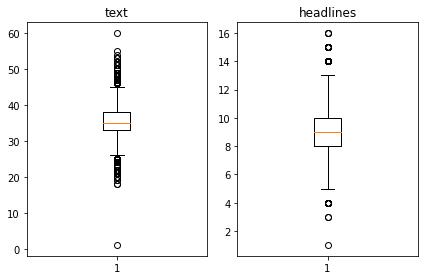

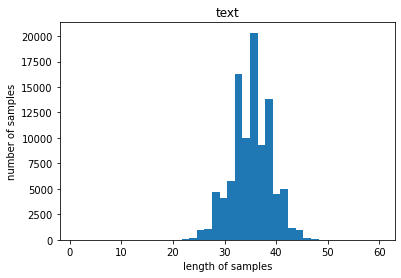

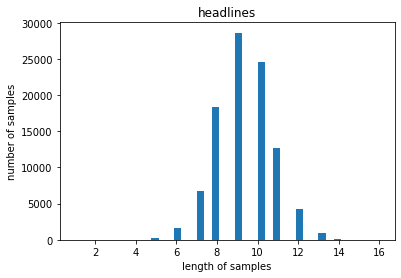

=3
=3
전체 샘플 중 길이가 25 이상, 45 이하인 샘플의 비율: 0.994408296055307
전체 샘플 중 길이가 7 이상, 12 이하인 샘플의 비율: 0.9683712891419276
전체 샘플수 : 94718


In [7]:
# 샘플의 최대 길이 정하기

# 길이 분포 출력
import matplotlib.pyplot as plt

text_len = [len(s.split()) for s in data['text']]
summary_len = [len(s.split()) for s in data['headlines']]

print('텍스트의 최소 길이 : {}'.format(np.min(text_len)))
print('텍스트의 최대 길이 : {}'.format(np.max(text_len)))
print('텍스트의 평균 길이 : {}'.format(np.mean(text_len)))
print('요약의 최소 길이 : {}'.format(np.min(summary_len)))
print('요약의 최대 길이 : {}'.format(np.max(summary_len)))
print('요약의 평균 길이 : {}'.format(np.mean(summary_len)))

plt.subplot(1,2,1)
plt.boxplot(text_len)
plt.title('text')
plt.subplot(1,2,2)
plt.boxplot(summary_len)
plt.title('headlines')
plt.tight_layout()
plt.show()

plt.title('text')
plt.hist(text_len, bins = 40)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

plt.title('headlines')
plt.hist(summary_len, bins = 40)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

# 이로부터 Text의 최대 길이와 Summary의 적절한 최대 길이를 임의로 정해
text_min_len = 25; text_max_len = 45
summary_min_len = 7; summary_max_len = 12
print('=3')

def below_threshold_len(min_len, max_len, nested_list):
  cnt = 0
  for s in nested_list:
    if(len(s.split()) >= min_len and len(s.split()) <= max_len):
        cnt = cnt + 1
  print('전체 샘플 중 길이가 %s 이상, %s 이하인 샘플의 비율: %s'%(min_len, max_len, (cnt / len(nested_list))))
print('=3')

below_threshold_len(text_min_len, text_max_len, data['text'])
below_threshold_len(summary_min_len, summary_max_len,  data['headlines'])

# 두 조건을 모두 충족하는 행만 필터링
data = data[data.apply(lambda row: (len(row['text'].split()) >= text_min_len and 
                                 len(row['text'].split()) <= text_max_len) and
                              (len(row['headlines'].split()) >= summary_min_len and 
                               len(row['headlines'].split()) <= summary_max_len), axis=1)]

# 결과 확인
print('전체 샘플수 :', len(data))

In [8]:
# 요약 데이터에는 시작 토큰과 종료 토큰을 추가한다.
data['decoder_input'] = data['headlines'].apply(lambda x : 'sostoken '+ x)
data['decoder_target'] = data['headlines'].apply(lambda x : x + ' eostoken')
data.head()

encoder_input = np.array(data['text']) # 인코더의 입력
decoder_input = np.array(data['decoder_input']) # 디코더의 입력
decoder_target = np.array(data['decoder_target']) # 디코더의 레이블
print('=3')

# 이제 훈련 데이터와 테스트 데이터를 분리할거에요. (이제 섞인 데이터를 8:2의 비율로 훈련 데이터와 테스트 데이터로 분리해 줄게요.)
indices = np.arange(encoder_input.shape[0])
np.random.shuffle(indices)
print(indices)

encoder_input = encoder_input[indices]
decoder_input = decoder_input[indices]
decoder_target = decoder_target[indices]
print('=3')

n_of_val = int(len(encoder_input)*0.2)
print('테스트 데이터의 수 :', n_of_val)

encoder_input_train = encoder_input[:-n_of_val]
decoder_input_train = decoder_input[:-n_of_val]
decoder_target_train = decoder_target[:-n_of_val]

encoder_input_test = encoder_input[-n_of_val:]
decoder_input_test = decoder_input[-n_of_val:]
decoder_target_test = decoder_target[-n_of_val:]

print('훈련 데이터의 개수 :', len(encoder_input_train))
print('훈련 레이블의 개수 :', len(decoder_input_train))
print('테스트 데이터의 개수 :', len(encoder_input_test))
print('테스트 레이블의 개수 :', len(decoder_input_test))

=3
[ 2575  6946 72383 ... 89167 14518  4713]
=3
테스트 데이터의 수 : 18943
훈련 데이터의 개수 : 75775
훈련 레이블의 개수 : 75775
테스트 데이터의 개수 : 18943
테스트 레이블의 개수 : 18943


In [9]:
# 단어 집합(vocabulary) 만들기 및 정수 인코딩 (빈도수가 낮은 단어들은 훈련 데이터에서 제외하고 진행하려고 해요.)

from tensorflow.keras.preprocessing.text import Tokenizer 
src_tokenizer = Tokenizer() # 토크나이저 정의
src_tokenizer.fit_on_texts(encoder_input_train) # 입력된 데이터로부터 단어 집합 생성
print('=3')

threshold = 7
total_cnt = len(src_tokenizer.word_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in src_tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :', total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print('단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 %s'%(total_cnt - rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

src_vocab = 20000
src_tokenizer = Tokenizer(num_words=src_vocab) # 단어 집합의 크기를 8,000으로 제한
src_tokenizer.fit_on_texts(encoder_input_train) # 단어 집합 재생성
print('=3')

# 텍스트 시퀀스를 정수 시퀀스로 변환
encoder_input_train = src_tokenizer.texts_to_sequences(encoder_input_train) 
encoder_input_test = src_tokenizer.texts_to_sequences(encoder_input_test)

# 잘 진행되었는지 샘플 출력
print(encoder_input_train[:3])

tar_tokenizer = Tokenizer()
tar_tokenizer.fit_on_texts(decoder_input_train)
print('=3')

threshold = 6
total_cnt = len(tar_tokenizer.word_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in tar_tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :', total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print('단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 %s'%(total_cnt - rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

tar_vocab = 10000
tar_tokenizer = Tokenizer(num_words=tar_vocab) 
tar_tokenizer.fit_on_texts(decoder_input_train)
tar_tokenizer.fit_on_texts(decoder_target_train)

# 텍스트 시퀀스를 정수 시퀀스로 변환
decoder_input_train = tar_tokenizer.texts_to_sequences(decoder_input_train) 
decoder_target_train = tar_tokenizer.texts_to_sequences(decoder_target_train)
decoder_input_test = tar_tokenizer.texts_to_sequences(decoder_input_test)
decoder_target_test = tar_tokenizer.texts_to_sequences(decoder_target_test)

# 잘 변환되었는지 확인
print('input')
print('input ',decoder_input_train[:5])
print('target')
print('decoder ',decoder_target_train[:5])

# 이 샘플들은 모두 삭제할 거예요.
drop_train = [index for index, sentence in enumerate(decoder_input_train) if len(sentence) == 1]
drop_test = [index for index, sentence in enumerate(decoder_input_test) if len(sentence) == 1]

print('삭제할 훈련 데이터의 개수 :', len(drop_train))
print('삭제할 테스트 데이터의 개수 :', len(drop_test))

encoder_input_train = [sentence for index, sentence in enumerate(encoder_input_train) if index not in drop_train]
decoder_input_train = [sentence for index, sentence in enumerate(decoder_input_train) if index not in drop_train]
decoder_target_train = [sentence for index, sentence in enumerate(decoder_target_train) if index not in drop_train]

encoder_input_test = [sentence for index, sentence in enumerate(encoder_input_test) if index not in drop_test]
decoder_input_test = [sentence for index, sentence in enumerate(decoder_input_test) if index not in drop_test]
decoder_target_test = [sentence for index, sentence in enumerate(decoder_target_test) if index not in drop_test]

print('훈련 데이터의 개수 :', len(encoder_input_train))
print('훈련 레이블의 개수 :', len(decoder_input_train))
print('테스트 데이터의 개수 :', len(encoder_input_test))
print('테스트 레이블의 개수 :', len(decoder_input_test))

# 패딩하기
from tensorflow.keras.preprocessing.sequence import pad_sequences
encoder_input_train = pad_sequences(encoder_input_train, maxlen=text_max_len, padding='post')
encoder_input_test = pad_sequences(encoder_input_test, maxlen=text_max_len, padding='post')
decoder_input_train = pad_sequences(decoder_input_train, maxlen=summary_max_len, padding='post')
decoder_target_train = pad_sequences(decoder_target_train, maxlen=summary_max_len, padding='post')
decoder_input_test = pad_sequences(decoder_input_test, maxlen=summary_max_len, padding='post')
decoder_target_test = pad_sequences(decoder_target_test, maxlen=summary_max_len, padding='post')
print('=3')

=3
단어 집합(vocabulary)의 크기 : 68176
등장 빈도가 6번 이하인 희귀 단어의 수: 46492
단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 21684
단어 집합에서 희귀 단어의 비율: 68.19408589532974
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 3.558382909355582
=3
[[30, 4803, 1382, 59, 1169, 1299, 1162, 125, 56, 8657, 8, 3058, 520, 1825, 2229, 8, 38, 43, 520, 558, 582, 3058, 2811, 3243, 865, 44, 726, 429, 636, 412], [126, 1772, 285, 233, 145, 3903, 2852, 54, 735, 999, 19089, 285, 1560, 145, 371, 5, 848, 5677, 296, 18044, 32, 2812, 371, 126, 2890, 4047, 141, 1773, 5629, 348, 2143, 5, 1101, 170, 85, 22, 691, 2114], [165, 19, 57, 9802, 5402, 1797, 2123, 2793, 3814, 19, 2609, 77, 2667, 3166, 2753, 330, 2793, 66, 3814, 617, 2065, 2175, 1416, 1, 248, 209, 2555, 11023, 143, 953, 617]]
=3
단어 집합(vocabulary)의 크기 : 29603
등장 빈도가 5번 이하인 희귀 단어의 수: 19388
단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 10215
단어 집합에서 희귀 단어의 비율: 65.49336215924062
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 4.759128939681566
input
input  [[1, 637, 1319, 1422, 4, 249, 41, 1971, 359], [1, 154, 45, 2467, 292, 1124, 3, 236, 3310, 

#### Step 3. 어텐션 메커니즘 사용하기 (추상적 요약)
일반적인 seq2seq보다는 어텐션 메커니즘을 사용한 seq2seq를 사용하는 것이 더 나은 성능을 얻을 수 있어요. 실습 내용을 참고하여 어텐션 메커니즘을 사용한 seq2seq를 설계해 보세요.

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 45)]         0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 45, 128)      2560000     input_1[0][0]                    
__________________________________________________________________________________________________
lstm (LSTM)                     [(None, 45, 256), (N 394240      embedding[0][0]                  
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, None)]       0                                            
______________________________________________________________________________________________

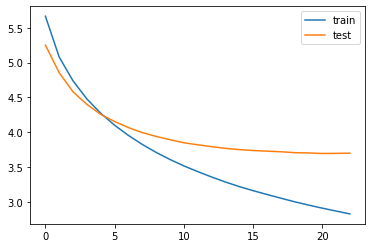

=3
=3
=3
=3


In [10]:
# 모델 설계하기

from tensorflow.keras.layers import Input, LSTM, Embedding, Dense, Concatenate, TimeDistributed
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint


# 인코더 설계 시작
embedding_dim = 128
hidden_size = 256

# 인코더
encoder_inputs = Input(shape=(text_max_len,))

# 인코더의 임베딩 층
enc_emb = Embedding(src_vocab, embedding_dim)(encoder_inputs)

# 인코더의 LSTM 1
# encoder_lstm1 = LSTM(hidden_size, return_sequences=True, return_state=True ,dropout = 0.4, recurrent_dropout = 0.4)
encoder_lstm1 = LSTM(hidden_size, return_sequences=True, return_state=True ,dropout = 0.4)
encoder_output1, state_h1, state_c1 = encoder_lstm1(enc_emb)

# 인코더의 LSTM 2
encoder_lstm2 = LSTM(hidden_size, return_sequences=True, return_state=True, dropout = 0.4)
encoder_output2, state_h2, state_c2 = encoder_lstm2(encoder_output1)

# 인코더의 LSTM 3
encoder_lstm3 = LSTM(hidden_size, return_sequences=True, return_state=True, dropout = 0.4)
encoder_outputs, state_h, state_c = encoder_lstm3(encoder_output2)

# 디코더 설계
decoder_inputs = Input(shape=(None,))

# 디코더의 임베딩 층
dec_emb_layer = Embedding(tar_vocab, embedding_dim)
dec_emb = dec_emb_layer(decoder_inputs)

# 디코더의 LSTM
# decoder_lstm = LSTM(hidden_size, return_sequences=True, return_state=True, dropout=0.4, recurrent_dropout=0.2)
decoder_lstm = LSTM(hidden_size, return_sequences=True, return_state=True, dropout=0.4)
decoder_outputs, _, _ = decoder_lstm(dec_emb, initial_state=[state_h, state_c])

# 디코더의 출력층
decoder_softmax_layer = Dense(tar_vocab, activation='softmax')
decoder_softmax_outputs = decoder_softmax_layer(decoder_outputs) 

# 모델 정의
model = Model([encoder_inputs, decoder_inputs], decoder_softmax_outputs)
model.summary()

from tensorflow.keras.layers import AdditiveAttention

# 어텐션 층(어텐션 함수)
attn_layer = AdditiveAttention(name='attention_layer')

# 인코더와 디코더의 모든 time step의 hidden state를 어텐션 층에 전달하고 결과를 리턴
attn_out = attn_layer([decoder_outputs, encoder_outputs])


# 어텐션의 결과와 디코더의 hidden state들을 연결
decoder_concat_input = Concatenate(axis=-1, name='concat_layer')([decoder_outputs, attn_out])

# 디코더의 출력층
decoder_softmax_layer = Dense(tar_vocab, activation='softmax')
decoder_softmax_outputs = decoder_softmax_layer(decoder_concat_input)

# 모델 정의
model = Model([encoder_inputs, decoder_inputs], decoder_softmax_outputs)
model.summary()

# 모델 훈련하기
model.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy')
es = EarlyStopping(monitor='val_loss', patience=2, verbose=1)
history = model.fit(x=[encoder_input_train, decoder_input_train], y=decoder_target_train, \
          validation_data=([encoder_input_test, decoder_input_test], decoder_target_test), \
          batch_size=256, callbacks=[es], epochs=50)

# 이제 훈련 데이터의 손실과 검증 데이터의 손실이 줄어드는 과정을 시각화 해봐요.
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

# 인퍼런스 모델 구현하기

src_index_to_word = src_tokenizer.index_word # 원문 단어 집합에서 정수 -> 단어를 얻음
tar_word_to_index = tar_tokenizer.word_index # 요약 단어 집합에서 단어 -> 정수를 얻음
tar_index_to_word = tar_tokenizer.index_word # 요약 단어 집합에서 정수 -> 단어를 얻음

print('=3')

# 인코더 설계
encoder_model = Model(inputs=encoder_inputs, outputs=[encoder_outputs, state_h, state_c])

# 이전 시점의 상태들을 저장하는 텐서
decoder_state_input_h = Input(shape=(hidden_size,))
decoder_state_input_c = Input(shape=(hidden_size,))

dec_emb2 = dec_emb_layer(decoder_inputs)

# 문장의 다음 단어를 예측하기 위해서 초기 상태(initial_state)를 이전 시점의 상태로 사용. 이는 뒤의 함수 decode_sequence()에 구현
# 훈련 과정에서와 달리 LSTM의 리턴하는 은닉 상태와 셀 상태인 state_h와 state_c를 버리지 않음.
decoder_outputs2, state_h2, state_c2 = decoder_lstm(dec_emb2, initial_state=[decoder_state_input_h, decoder_state_input_c])

print('=3')

# 어텐션 함수
decoder_hidden_state_input = Input(shape=(text_max_len, hidden_size))
attn_out_inf = attn_layer([decoder_outputs2, decoder_hidden_state_input])
decoder_inf_concat = Concatenate(axis=-1, name='concat')([decoder_outputs2, attn_out_inf])

# 디코더의 출력층
decoder_outputs2 = decoder_softmax_layer(decoder_inf_concat) 

# 최종 디코더 모델
decoder_model = Model(
    [decoder_inputs] + [decoder_hidden_state_input,decoder_state_input_h, decoder_state_input_c],
    [decoder_outputs2] + [state_h2, state_c2])

print('=3')

def decode_sequence(input_seq):
    # 입력으로부터 인코더의 상태를 얻음
    e_out, e_h, e_c = encoder_model.predict(input_seq)

     # <SOS>에 해당하는 토큰 생성
    target_seq = np.zeros((1,1))
    target_seq[0, 0] = tar_word_to_index['sostoken']

    stop_condition = False
    decoded_sentence = ''
    while not stop_condition: # stop_condition이 True가 될 때까지 루프 반복

        output_tokens, h, c = decoder_model.predict([target_seq] + [e_out, e_h, e_c])
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_token = tar_index_to_word[sampled_token_index]

        if (sampled_token!='eostoken'):
            decoded_sentence += ' '+sampled_token

        #  <eos>에 도달하거나 최대 길이를 넘으면 중단.
        if (sampled_token == 'eostoken'  or len(decoded_sentence.split()) >= (summary_max_len-1)):
            stop_condition = True

        # 길이가 1인 타겟 시퀀스를 업데이트
        target_seq = np.zeros((1,1))
        target_seq[0, 0] = sampled_token_index

        # 상태를 업데이트 합니다.
        e_h, e_c = h, c

    return decoded_sentence
print('=3')

#### Step 4. 실제 결과와 요약문 비교하기 (추상적 요약)
원래의 요약문(headlines 열)과 학습을 통해 얻은 추상적 요약의 결과를 비교해 보세요.

In [11]:
# 모델 테스트하기

# 원문의 정수 시퀀스를 텍스트 시퀀스로 변환
def seq2text(input_seq):
    temp=''
    for i in input_seq:
        if (i!=0):
            temp = temp + src_index_to_word[i]+' '
    return temp

# 요약문의 정수 시퀀스를 텍스트 시퀀스로 변환
def seq2summary(input_seq):
    temp=''
    for i in input_seq:
        if (i!=0):
            temp = temp + src_index_to_word[i]+' '
    return temp

print('=3')

# 테스트 데이터 약 50개의 샘플에 대해서 실제 요약과 예측된 요약을 비교해보세요.
for i in range(50, 100):
    print("원문 :", seq2text(encoder_input_test[i]))
    print("실제 요약 :", seq2summary(decoder_input_test[i]))
    print("예측 요약 :", decode_sequence(encoder_input_test[i].reshape(1, text_max_len)))
    print("\n")

=3
원문 : many shops restaurants delhi airport could hinder evacuations lives passengers emergency parliamentary panel concluded draft report said advice security agencies overlooked commercial interests delhi international airport limited civil aviation ministry ignored safety concerns report claimed 
실제 요약 : said japan religious rawat old delhi third four benz afghanistan 
예측 요약 :  delhi airport to be banned for days after ban


원문 : film critic mahesh banned entering hyderabad six months telangana police controversial remarks lord ram ramayana made recently television debate show taken city dropped native place chittoor district said telangana dgp reddy 
실제 요약 : said monday conspiring big minister weeks us founder film rider england 
예측 요약 :  protests issued against dera over remarks on babri demolition


원문 : vicky kaushal responding katrina kaif comment would like work said surprised knows existence love coming way great koffee karan season karan johar asked katrina newcomer would l

예측 요약 :  farhan akhtar shares picture from her th birthday


원문 : british mps tuesday voted favour bill end supremacy european union law uk bill aimed law britain joined eu prime minister theresa may welcomed vote saying bill offered clarity 
실제 요약 : said telecom face secretary pakistan scheme added ceremony rbi 
예측 요약 :  uk parliament bill to brexit bill


원문 : canadian air traffic controllers bought hundreds pizzas american counterparts received salaries due partial us government shutdown around air traffic controllers us working without pay since shutdown imposed december notably ongoing government shutdown longest us history 
실제 요약 : said allow china citizens bring ugly year chelsea two 
예측 요약 :  us air force flights to fly over air strike


원문 : youth run international organisation exposed around four lakh intern applications server without password security researcher bob said leaked data included affected applicant name date birth email gender global vice president information m

예측 요약 :  cook scores in test after st test ton in test


원문 : army jawan martyred tuesday pakistani troops violated ceasefire firing across line control jammu kashmir poonch district according officials pakistan army initiated unprovoked firing indian army posts krishna sector around hours today indian army retaliated strongly effectively officials added 
실제 요약 : said board wicketkeeper source added spacecraft footballer one take 
예측 요약 :  jawans martyred in ceasefire violation by pak in pakistan


원문 : bid improve voter turnout upcoming gujarat assembly polls chief electoral officer surat mahendra patel send personalised invitation card family surat cards also contain information voter verifiable paper audit trail system order make people aware system functioning patel said 
실제 요약 : said selling festival mla presentation iphone year acquire added fifties 
예측 요약 :  gujarat election first voter voter ids in gujarat


원문 : millie bobby brown stars netflix series stranger things named uni

#### 회고
---
- 일부 원문과 실제 요약 내용이 크게 달랐음 (사용한 데이터가 좋은 데이터는 아닌 것 같음)
- 어텐션 메커니즘을 사용한 seq2seq를 사용해보았지만, 보이는 결과가 동문서답은 아닌데 꽤 나쁘지 않았음
- 이걸 서비스하면 article 제목 작성으로 하고 싶음

#### Step 5. Summa을 이용해서 추출적 요약해보기
추상적 요약은 추출적 요약과는 달리 문장의 표현력을 다양하게 가져갈 수 있지만, 추출적 요약에 비해서 난이도가 높아요. 반대로 말하면 추출적 요약은 추상적 요약에 비해 난이도가 낮고 기존 문장에서 문장을 꺼내오는 것이므로 잘못된 요약이 나올 가능성이 낮아요.

Summa의 summarize를 사용하여 추출적 요약을 해보세요.

In [12]:
import urllib.request
urllib.request.urlretrieve("https://raw.githubusercontent.com/sunnysai12345/News_Summary/master/news_summary_more.csv", filename="news_summary_more.csv")
data = pd.read_csv('news_summary_more.csv', encoding='iso-8859-1')

In [13]:
# 패키지 설치

!pip list | grep summa

# 데이터 다운로드하기

from summa.summarizer import summarize

# import os
# home = os.getenv('HOME')
# path = os.path.join(home, 'data', 'The_matrix_synopsis.txt')
# with open(path, encoding = 'UTF-8') as f:
#     text = f.read()
# 처음 50개 문서 요약
for i in range(50):
#     if i >= len(data):
#         break
        
    text = data['text'].iloc[i]
    
    print(f"\n문서 {i+1}:", text)
    summary = summarize(text, ratio=0.5)
    
    if summary:
        print("-" * 30)
        print('Summary:', summary)
    else:
        print("요약 실패. 원본 텍스트 일부:")
        print(text[:100] + "..." if len(text) > 100 else text)

print("요약 완료!")

# print(text[:1500])

# summarize 사용하기

# print('Summary:')
# print(summarize(text, ratio=0.005))

# print('Summary:')
# print(summarize(text, ratio=0.005, split=True))

# print('Summary:')
# print(summarize(text, words=50))

summa                         1.2.0

문서 1: Saurav Kant, an alumnus of upGrad and IIIT-B's PG Program in Machine learning and Artificial Intelligence, was a Sr Systems Engineer at Infosys with almost 5 years of work experience. The program and upGrad's 360-degree career support helped him transition to a Data Scientist at Tech Mahindra with 90% salary hike. upGrad's Online Power Learning has powered 3 lakh+ careers.
------------------------------
Summary: upGrad's Online Power Learning has powered 3 lakh+ careers.

문서 2: Kunal Shah's credit card bill payment platform, CRED, gave users a chance to win free food from Swiggy for one year. Pranav Kaushik, a Delhi techie, bagged this reward after spending 2000 CRED coins. Users get one CRED coin per rupee of bill paid, which can be used to avail rewards from brands like Ixigo, BookMyShow, UberEats, Cult.Fit and more.
------------------------------
Summary: Users get one CRED coin per rupee of bill paid, which can be used to avail rewards fro


문서 39: A Singapore-based insurance agent has been jailed for two years and five months for threatening to harm his clients unless they paid him in bitcoins. The 36-year-old set up an email account, and signed the messages as 'Lord Voldemort', a fictional character from the Harry Potter series. Ye Lin Myint targeted about 33 people, including those who cancelled insurance policies.
------------------------------
Summary: A Singapore-based insurance agent has been jailed for two years and five months for threatening to harm his clients unless they paid him in bitcoins.

문서 40: Gabrielle Reilly, a 22-year-old US woman, created earrings for her Apple AirPods and put it up for sale online for $20 (about Ã¢ÂÂ¹1,500). "I absolutely refuse to lose them (AirPods)...So I made earrings," she explained. The earrings, which took her over an hour to make, debuted in a video on Twitter that has since garnered over three million views.
------------------------------
Summary: "I absolutely refuse to 

|제목|Abstractive 요약|Extractive 요약|
|:------:|---|---|
|요약 결과|disha patani features on cover of vogue india cover|Actress Disha Patani has featured on the cover of the May edition of fashion magazine 'Cosmopolitan'.|
|문법완성도|떨어짐|완성도 있음|
|핵심단어 포함|일부 포함|의미적으로 틀릴 때 있음|